In [6]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import skimage.io

In [7]:
#%% Prepare model.
class UNet128(torch.nn.Module):
    """Takes in patches of 128^2 RGB, returns 88^2"""
    
    def __init__(self, out_channels=2):
        super().__init__()

        # learnable
        self.conv1A = torch.nn.Conv2d(3, 8, 3)  
        self.conv1B = torch.nn.Conv2d(8, 8, 3)  
        self.conv2A = torch.nn.Conv2d(8, 16, 3)  
        self.conv2B = torch.nn.Conv2d(16, 16, 3)  
        self.conv3A = torch.nn.Conv2d(16, 32, 3)  
        self.conv3B = torch.nn.Conv2d(32, 32, 3)  
        self.conv4A = torch.nn.Conv2d(32, 16, 3)  
        self.conv4B = torch.nn.Conv2d(16, 16, 3)  
        self.conv5A = torch.nn.Conv2d(16, 8, 3)  
        self.conv5B = torch.nn.Conv2d(8, 8, 3)  
        self.convfinal = torch.nn.Conv2d(8, out_channels, 1)         
        self.convtrans34 = torch.nn.ConvTranspose2d(32, 16, 2, stride=2) 
        self.convtrans45 = torch.nn.ConvTranspose2d(16, 8, 2, stride=2)
        
        # convenience
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)        
       
    def forward(self, x):
 
        # down
        l1 = self.relu(self.conv1B(self.relu(self.conv1A(x))))
        l2 = self.relu(self.conv2B(self.relu(self.conv2A(self.pool(l1)))))
        out = self.relu(self.conv3B(self.relu(self.conv3A(self.pool(l2))))) 
        
        # up 
        out = torch.cat([self.convtrans34(out), l2[:,:,4:-4,4:-4]], dim=1)
        out = self.relu(self.conv4B(self.relu(self.conv4A(out))))
        out = torch.cat([self.convtrans45(out), l1[:,:,16:-16,16:-16]], dim=1)      
        out = self.relu(self.conv5B(self.relu(self.conv5A(out))))
   
         # finishing
        out = self.convfinal(out)
  
        return out

In [8]:
# Initiate the model
model = UNet128()

In [10]:
#%%  Get (if needed) and load the trained model.
import os
filename = os.path.join('..', 'Data', 'week10', 'checkpoint_500.pth')
# if not os.path.isfile(os.pat.join('checkopoint_500.pth'):
#     !wget 'http://www2.imm.dtu.dk/courses/02506/data/week10/checkpoint_500.pth' -q
# model.load_state_dict(torch.load('checkpoint_500.pth')['model_statedict'])
model.load_state_dict(torch.load(filename)['model_statedict'])

<All keys matched successfully>

In [11]:
# Retreive test images (original, bigger gland images) and extract. 
# (Unless files already are in work space)
import shutil
import os
# if not os.path.isfile('Gland_test.zip'):  
#     !wget -q http://www2.imm.dtu.dk/courses/02506/data/Gland_test.zip
# if not os.path.isdir('Gland_test'):
#     shutil.unpack_archive('Gland_test.zip', 'Gland_test')
datadir = os.path.join('..', 'Data', 'Gland_test')  # path to the directory containing data

## Task 1, network architecture
```
128x3 126x8 124x8                                   (92+92)x8 90x8 88x8 88x1
            62x8 60x16 58x16       (50+50)x16 48x16 46x16                 
                       29x16 27x32 25x32
```

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


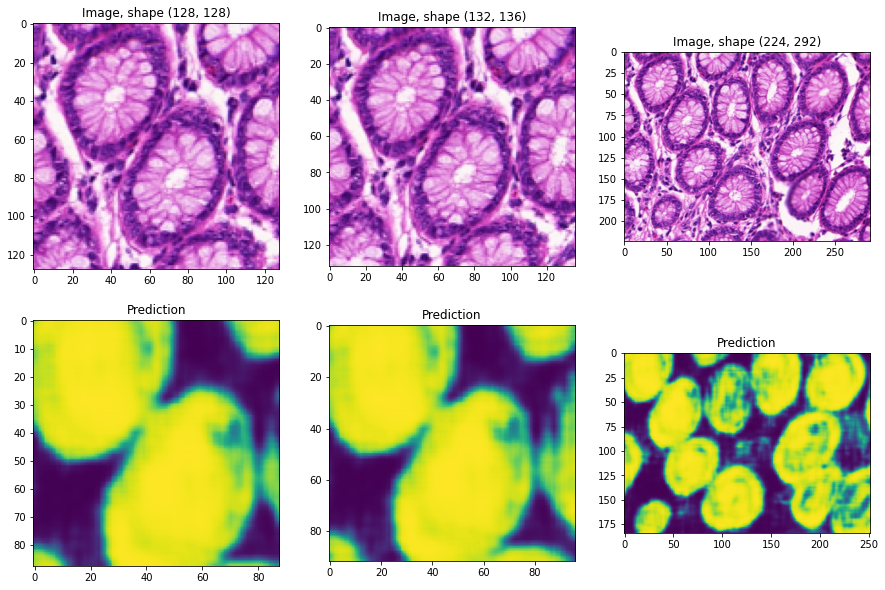

In [12]:
# TASK 2, INVESTIGATING POSSIBLE INPUT SIZES

image = skimage.io.imread(os.path.join(datadir, 'test_003.png'))

shapes = [(128,128), (128+4, 128+8), (4*(image.shape[0]//4), 4*(image.shape[1]//4))]
fig, ax = plt.subplots(2, len(shapes), figsize=(15, 10))

for n, s in enumerate(shapes):
    img = torch.tensor(image[:s[0], :s[1], :].transpose(2, 0, 1), dtype=torch.float32)/255
    lgt = model(img.unsqueeze(0))
    prob = torch.nn.functional.softmax(lgt, dim=1)

    ax[0, n].imshow(img.permute(1,2,0))
    ax[0, n].set_title(f'Image, shape {s}')
    ax[1, n].imshow(prob[0,1].detach())
    ax[1, n].set_title('Prediction')
plt.show()


In [13]:
# TASK 3, LOOKING AT FILTER WEIGHTS

# Checking the weights
print('** Model architecture: ')
print(model)
print('\n** Learnable parameters in layers: ')
nr_parameters = 0
for p in model.parameters():
  print(p.shape)
  nr_parameters += p.numel()
print(f'\n** In total: {nr_parameters} parameters')

** Model architecture: 
UNet128(
  (conv1A): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv1B): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2A): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2B): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3A): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3B): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4A): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4B): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv5A): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv5B): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (convfinal): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
  (convtrans34): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (convtrans45): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

** Learnable parameters in layers: 



** One convolutional layer: 
Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))

** Weights shape: 
torch.Size([8, 3, 3, 3])


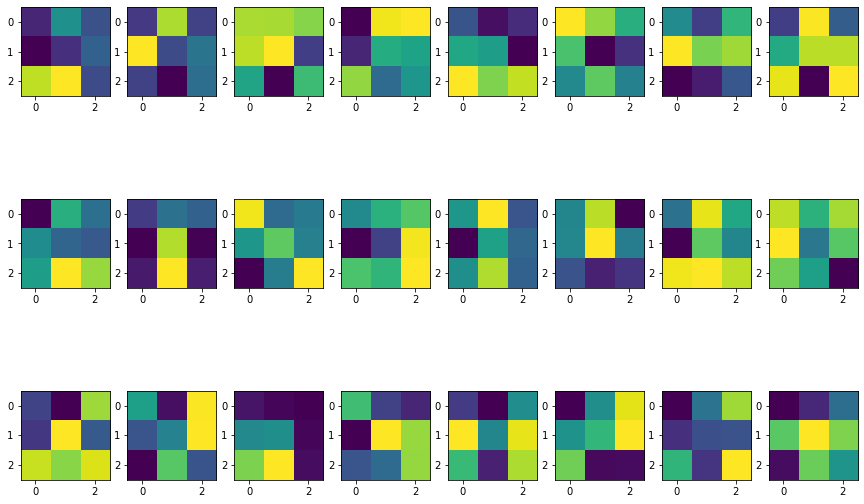

In [14]:
# Looking at one particular convolutional layer
layer = model.conv1A
print('\n** One convolutional layer: ')
print(layer)
print('\n** Weights shape: ')
print(layer.weight.shape)

jj, ii = layer.weight.shape[:2]
fig, ax = plt.subplots(ii, jj, figsize=(15, 10))
for i in range(ii):
    for j in range(jj):
        ax[i, j].imshow(layer.weight[j, i, :, :].detach())

In [15]:
# TASK 4, LOOKING AT LAYER OUTPUT
# There are different ways of getting layer outputs. Here showing one approach.

def forward_hacked(self, x):
    ''' 
    One way of getting the intermediate layers is to hack into the forward
    method. You can then return whatever you wish together with the original
    output. Here we ouput the results after each convolutional block.
    
    NB This function is outside class definition, so variable 'self' here is 
    just a variable (I'm to lazy to change it to e.g. model). 
    '''

    # down
    l1 = self.relu(self.conv1B(self.relu(self.conv1A(x))))
    l2 = self.relu(self.conv2B(self.relu(self.conv2A(self.pool(l1)))))
    out = self.relu(self.conv3B(self.relu(self.conv3A(self.pool(l2)))))
    l3 = out.clone()
    
    # up 
    out = torch.cat([self.convtrans34(out), l2[:,:,4:-4,4:-4]], dim=1)
    out = self.relu(self.conv4B(self.relu(self.conv4A(out))))
    l4 = out.clone()
    out = torch.cat([self.convtrans45(out), l1[:,:,16:-16,16:-16]], dim=1)     
    out = self.relu(self.conv5B(self.relu(self.conv5A(out))))
    l5 = out.clone()

    # finishing
    out = self.convfinal(out)

    return out, l1, l2, l3, l4, l5

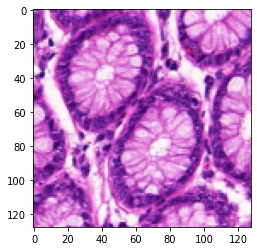

In [16]:
#  Image to work on, choosing 128x128 again to have sizes af for intended use
image = skimage.io.imread(os.path.join(datadir, 'test_003.png'))
image = image[:128, :128]
img = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)/255
fig, ax = plt.subplots()
ax.imshow(image)
plt.show()

In [17]:
# Getting outputs of confolutional blocks, compare with sizes from task 1
out, l1, l2, l3, l4, l5 = forward_hacked(model, img.unsqueeze(0))
for layer in [l1, l2, l3, l4, l5]:
    print(layer.shape)
  

torch.Size([1, 8, 124, 124])
torch.Size([1, 16, 58, 58])
torch.Size([1, 32, 25, 25])
torch.Size([1, 16, 46, 46])
torch.Size([1, 8, 88, 88])


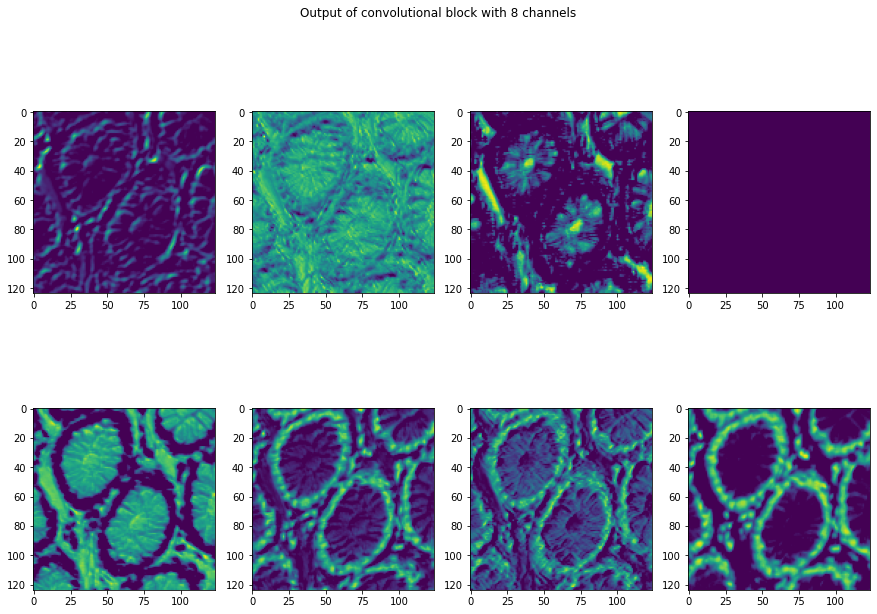

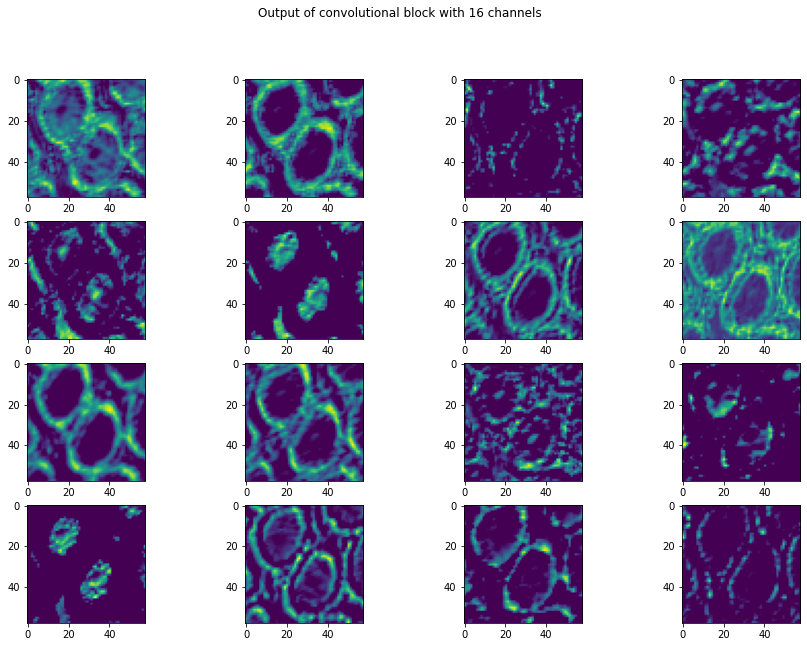

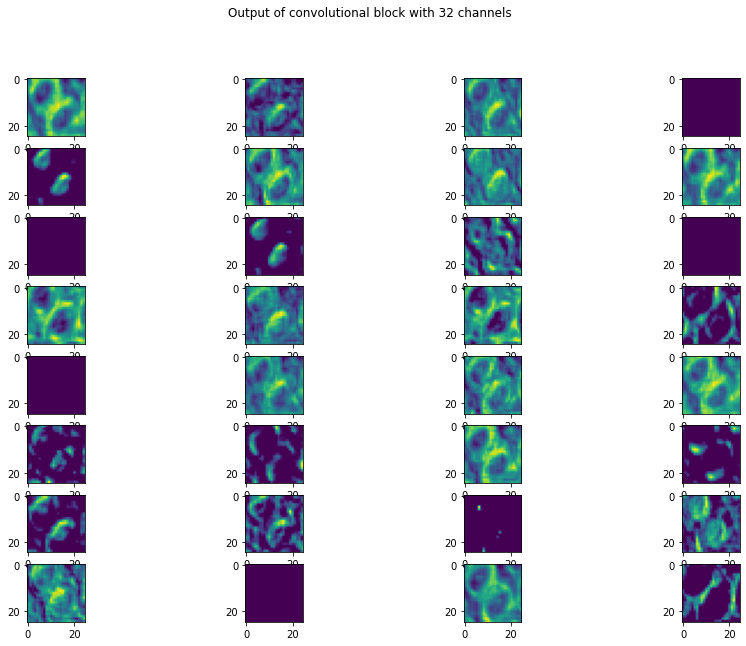

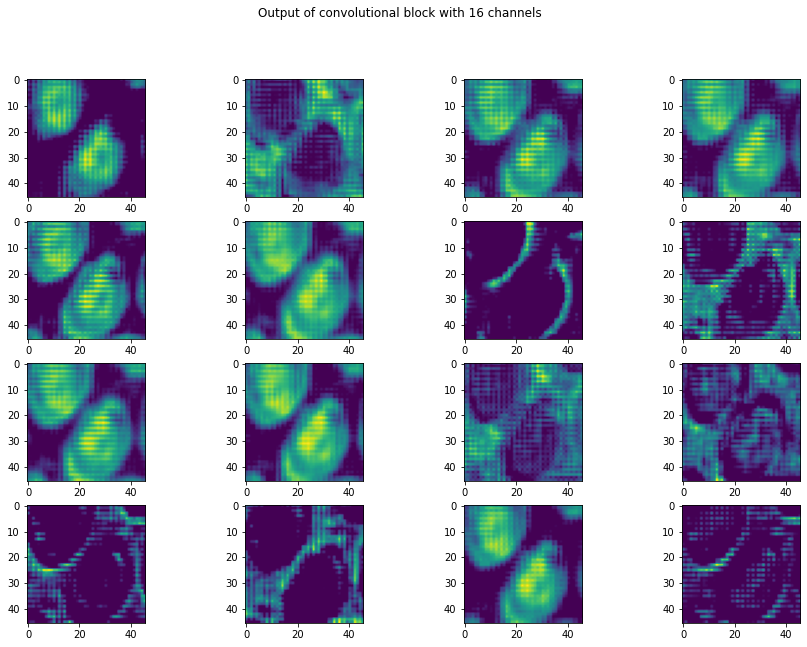

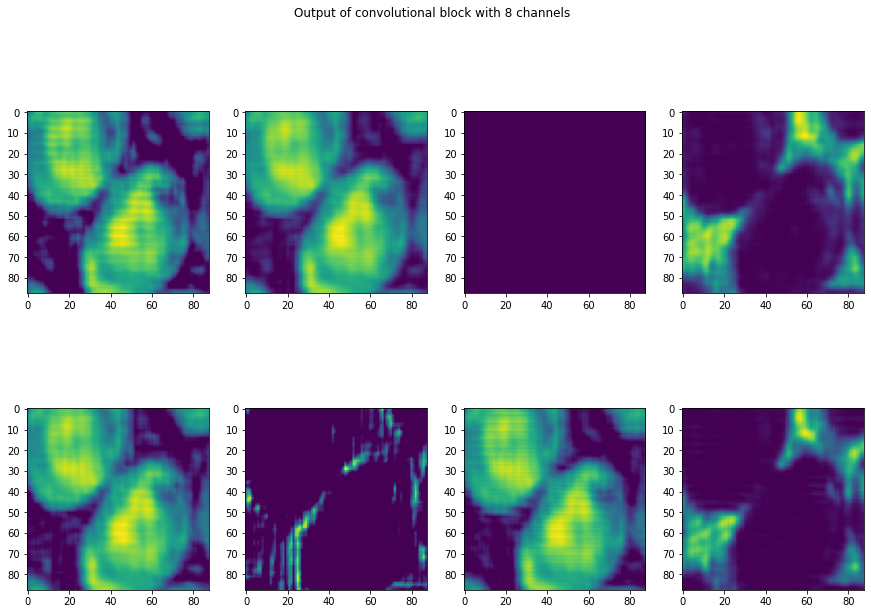

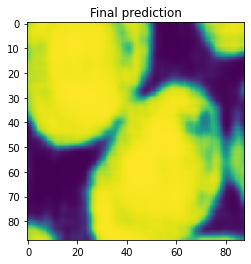

In [18]:
# Visualizing outputs of convolutional blocks
for layer in [l1, l2, l3, l4, l5]:
  ch = int(layer.shape[1])
  fig, ax = plt.subplots(ch//4, 4, figsize = (15, 10))
  ax = ax.ravel()
  for i in range(ch):
      ax[i].imshow(layer[0,i,:,:].detach().detach())
  fig.suptitle(f'Output of convolutional block with {ch} channels')

prob = torch.nn.functional.softmax(out, dim=1)
fig, ax = plt.subplots()
ax.imshow(prob[0,1].detach())
ax.set_title('Final prediction')
plt.show()
